![ups logo](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Logo_Universidad_Polit%C3%A9cnica_Salesiana_del_Ecuador.png/640px-Logo_Universidad_Polit%C3%A9cnica_Salesiana_del_Ecuador.png)

## Aprendizaje Automático P64

## Practica 04


### Árboles de decisión, Random Forest (RF) y Máquinas de Soporte Vectorial (SVM)

### Fase 2: Entrenamiento de un Random Forest

### Autor: Diego Tapia

### Importación de librerías
<a id="importacion-de-librerias"></a>

In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt 

from time import time
from datetime import datetime, timedelta

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout

import keras
from keras.models import model_from_json
from keras.models import load_model

from sklearn import metrics 
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn import set_config   
from sklearn.ensemble import RandomForestClassifier

print("Módulos y clases importados")

2024-06-13 15:07:59.830165: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 15:08:01.565919: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Módulos y clases importados


### Carga del dataset

Se carga el dataset procesado de la fase 1

In [2]:
dataframe = pd.read_csv('dataset/dataset_processed_heart_failure.csv', sep=',', header=0)

dataframe.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,Y
0,55.0,0,748,0,45,0,263358.03,1.3,137,male,1,88,0
1,65.0,0,56,0,25,0,305000.00,5.0,130,male,0,207,0
2,45.0,0,582,1,38,0,319000.00,0.9,140,female,0,244,0
3,60.0,1,754,1,40,1,328000.00,1.2,126,male,0,90,0
4,95.0,1,582,0,30,0,461000.00,2.0,132,male,0,50,1


Se extrae la variable de salida 'Y'

In [3]:
Y = dataframe['Y']
dataframe.drop(['Y'], axis=1, inplace=True)
dataframe.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,55.0,0,748,0,45,0,263358.03,1.3,137,male,1,88
1,65.0,0,56,0,25,0,305000.00,5.0,130,male,0,207
2,45.0,0,582,1,38,0,319000.00,0.9,140,female,0,244
3,60.0,1,754,1,40,1,328000.00,1.2,126,male,0,90
4,95.0,1,582,0,30,0,461000.00,2.0,132,male,0,50


### Carga del Pipeline

Se carga el pipeline obtenido en la fase 1

In [4]:
def cargarPipeline(nombreArchivo):
    with open(nombreArchivo+'.pickle', 'rb') as handle:
        pipeline = pickle.load(handle)
    return pipeline

In [5]:
nombreArchivoPreprocesador='pipeline_heart_failure'
pipe=None
pipe=cargarPipeline(nombreArchivoPreprocesador) #Debes incluir el archivo del Pipeline en el mismo directorio del script 
cantidadPasos=len(pipe.steps)
print("Cantidad de pasos: ",cantidadPasos)
set_config(display='diagram')
pipe

Cantidad de pasos:  2


/home/diego/UPS/MachineLearning/Unidad 2/Practica04_RandonForest_SVM/mlvenv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1624: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('prepcn',
                 ColumnTransformer(n_jobs=2, remainder='passthrough',
                                   transformers=[('catnom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex'])])),
                ('prepminmax',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tranminmax',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12])]))])

### Creación del Random Forest

In [6]:
random_forest = RandomForestClassifier(n_estimators=200, max_depth=25, random_state=42)

pipe.steps.append(['modelRandomForest',random_forest])

print("Cantidad de pasos: ",len(pipe.steps))

Cantidad de pasos:  3


### Entrenamiento del modelo

In [7]:
# Se divide el dataset en train y test
X = copy.deepcopy(dataframe)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state=42)

print("Conjuntos train y test creados")

Conjuntos train y test creados


In [8]:
modelo_entrenado = pipe.fit(X_train, y_train)

print("Entrenamiento terminado")

Entrenamiento terminado


### Predicción con modelo base y evaluación de calidad: MAE, MSE, RMSE, Accuracy, Precision, Recall y F1

In [9]:
y_pred = pipe.predict(X_test)
#y_pred

In [10]:
dataframeFinal=pd.DataFrame({'real':y_test, 'predicción': y_pred})

np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})

dataframeFinal.head(20)

,real,predicción
1501,0,0
2586,1,1
2653,1,1
1055,1,1
705,0,0
106,0,0
589,0,0
2468,0,0
2413,0,0
1600,0,0


In [11]:
from sklearn import metrics 
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score

MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
accuracy=str(accuracy_score(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)  
print('Mean Squared Error (MSE):', MSE)  
print('Root Mean Squared Error (RMSE):', RMSE) 
print('Accuracy: ' + accuracy) 

print('Confusion_matrix:')
y_test_transformado = y_test
y_pred_transformado = y_pred

cm = confusion_matrix(y_test_transformado, y_pred_transformado)  
print(cm)  
tn, fp, fn, tp = confusion_matrix(y_test_transformado, y_pred_transformado).ravel()  
print(tn,fp,fn,tp)

precision=precision_score(y_test_transformado, y_pred_transformado)
precision=str(round(precision, 4))
print('Precision:',precision)

recall=recall_score(y_test_transformado, y_pred_transformado)
recall=str(round(recall, 4))
print('Recall:',recall)

f1=f1_score(y_test_transformado, y_pred_transformado)
f1=str(round(f1, 4))
print('F1:',f1)

Mean Absolute Error (MAE): 0.007
Mean Squared Error (MSE): 0.007
Root Mean Squared Error (RMSE): 0.0837
Accuracy: 0.993
Confusion_matrix:
[[693   5]
 [  2 300]]
693 5 2 300
Precision: 0.9836
Recall: 0.9934
F1: 0.9885


### Prediccion

In [12]:
def predecirNuevoPaciente(age='86', anaemia=1, creatinine_phosphokinase=682, diabetes=1,
                            ejection_fraction=45, high_blood_pressure=1, platelets=310000, serum_creatinine=4, 
                            serum_sodium=135, sex='female', smoking=1, time=90):   
     
    cnames=['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex' ,'smoking', 'time']
    Xnew=[age, anaemia, creatinine_phosphokinase, diabetes, ejection_fraction, high_blood_pressure, platelets, serum_creatinine, serum_sodium, sex, smoking, time]
    Xnew_Dataframe = pd.DataFrame(data=[Xnew],columns=cnames)
    
    
    pred = (pipe.predict(Xnew_Dataframe) > 0.5).astype("int32")
    pred = pred.flatten()[0]# de 2D a 1D
    return pred

In [13]:
prediccion = predecirNuevoPaciente()
print(f"Prediccion : {prediccion}")
if(prediccion == 0):
    print("El paciente sobrevive")
else:
    print("El paciente fallece")

Prediccion : 1
El paciente fallece


### Visualizacion

In [23]:
pipe

Pipeline(steps=[('prepcn',
                 ColumnTransformer(n_jobs=2, remainder='passthrough',
                                   transformers=[('catnom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex'])])),
                ('prepminmax',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tranminmax',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12])])),
                ['modelRandomForest',
                 RandomForestClassifier(max_depth=25, n_estimators=200,
                                        random_state=42)]])

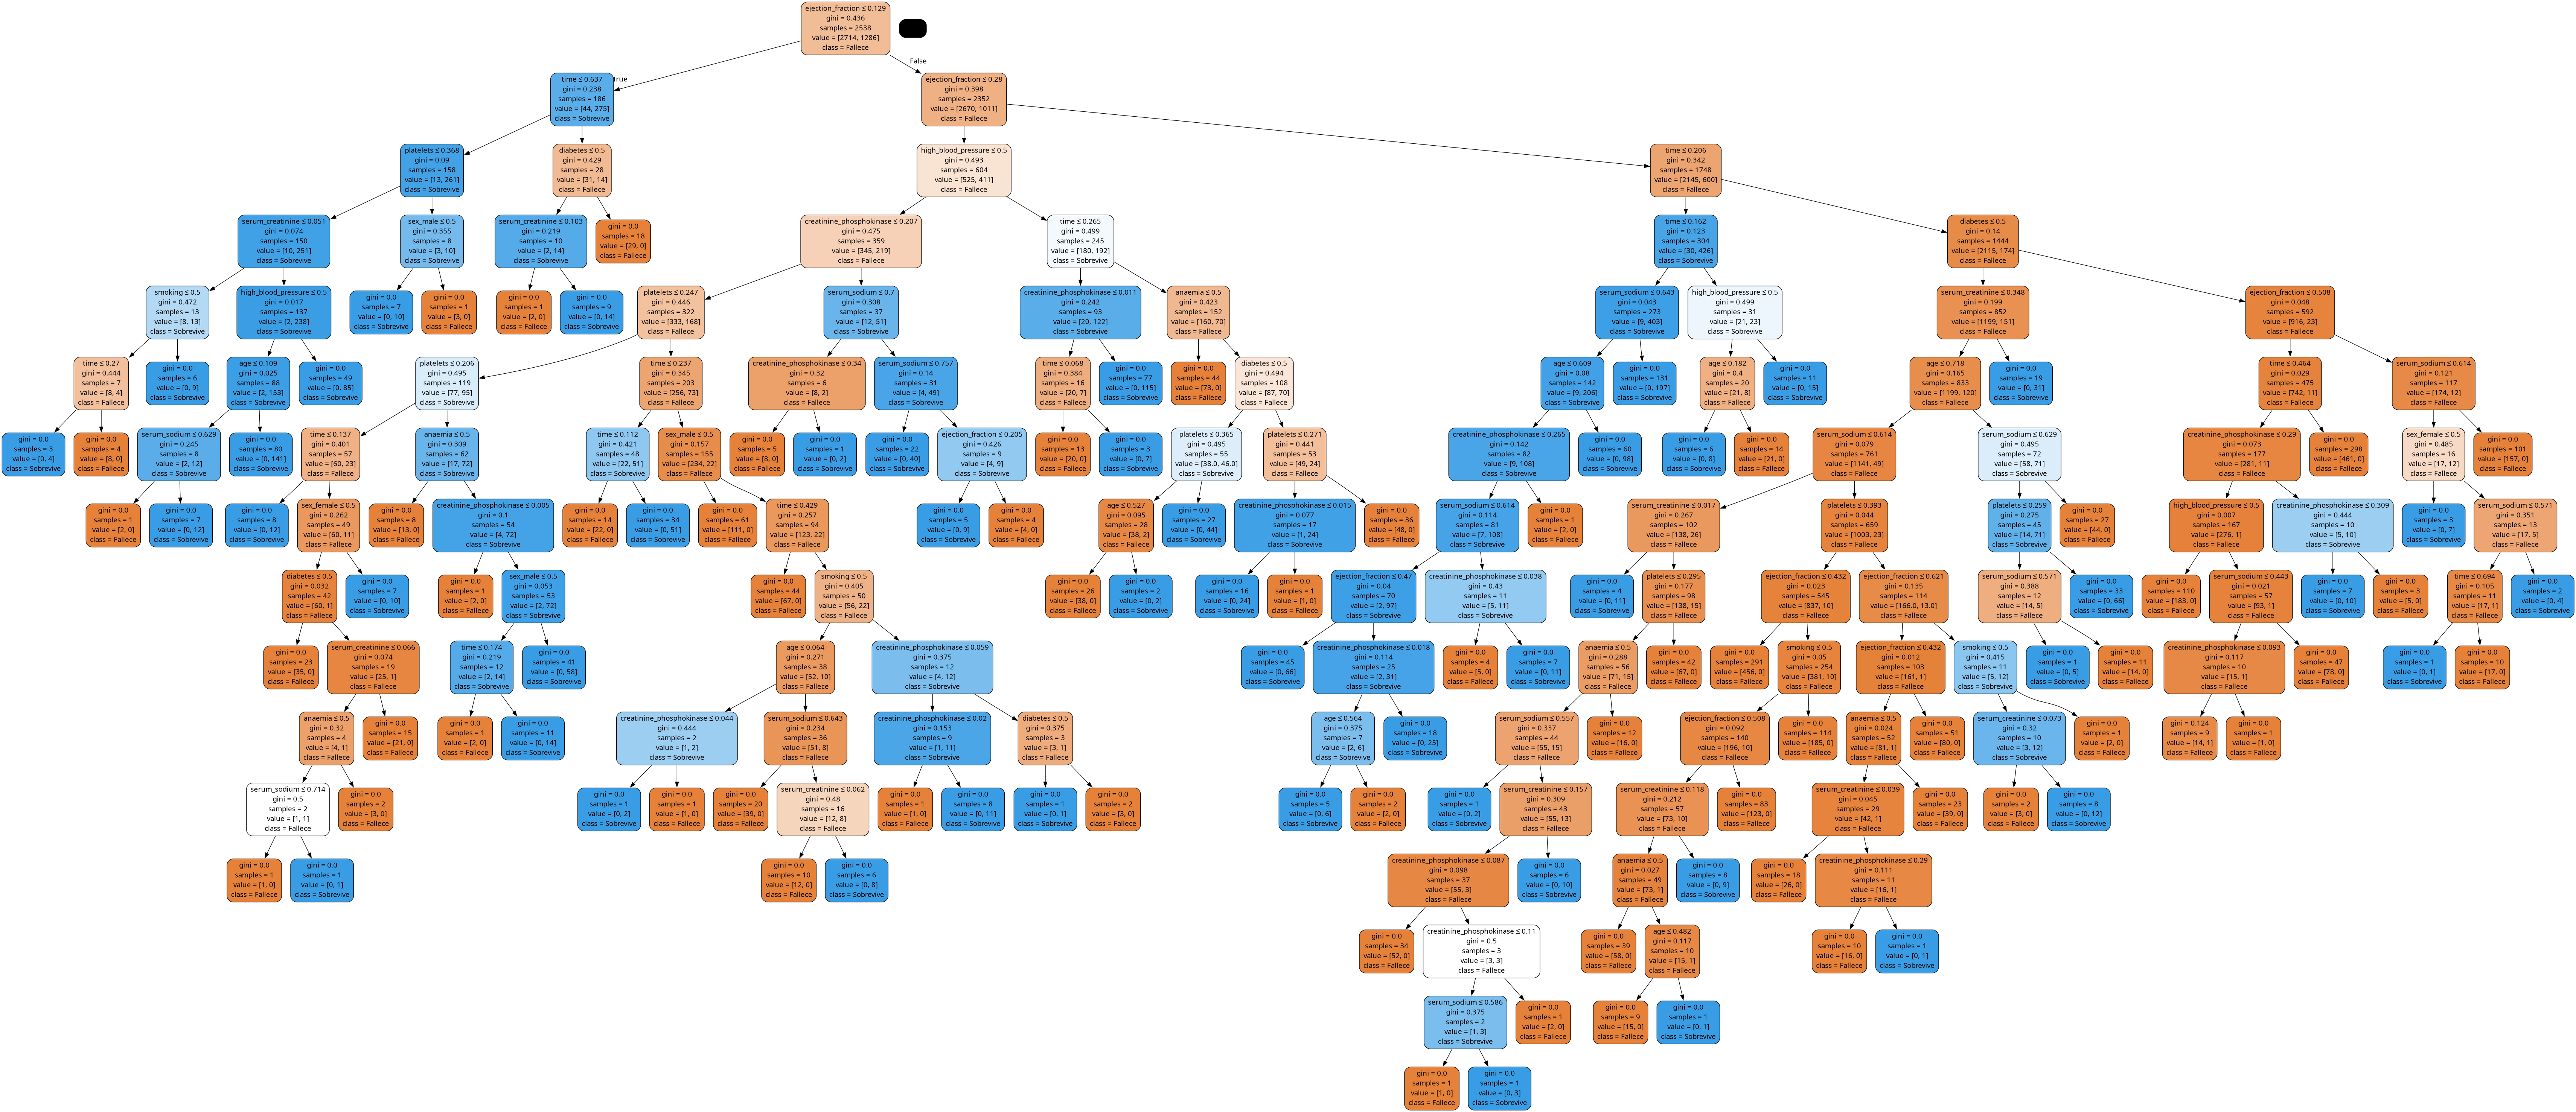

In [24]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
import graphviz

forest = pipe.named_steps['modelRandomForest']
estimator = forest.estimators_[10]
#sex_female,sex_male,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,smoking,time
cnames=['sex_female','sex_male','age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium','smoking', 'time']
dot_data = export_graphviz(estimator, 
                           out_file=None, 
                           feature_names=cnames,  
                           class_names=['Fallece', 'Sobrevive'],  
                           filled=True, 
                           rounded=True,  
                           special_characters=True)  

# Visualizar el árbol
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [25]:

# Obtener la importancia de las características
importances = forest.feature_importances_

# Crear un DataFrame para visualizar la importancia de las características
feature_names = cnames
feature_importances = pd.DataFrame(importances, index=feature_names, columns=['importance']).sort_values('importance', ascending=False)

feature_importances.head()

,importance
time,0.378367
serum_creatinine,0.144224
ejection_fraction,0.118229
age,0.088271
creatinine_phosphokinase,0.071915
